**Importing Libraries**

In [ ]:
# Importing libraries
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
#!pip install tensorflow==2.1.0
#!pip install keras==2.3.1
%matplotlib inline
from keras.layers import  Dense
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras_preprocessing.image import ImageDataGenerator

#pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')



**1-Mounting and extracting data from drive**

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

def path_extractor(zipPATH,zip_file,trgt_dir):
  # Extracting content, if "trgt_dir" not present
  if 'Grad-CAM heatmaps' not in os.listdir('.'):
    with zipfile.ZipFile(zipPATH+zip_file,"r") as z:
            print(f"Extracting content from {zip_file} ......")
            z.extractall()
            print(f"Extracted to {os.getcwd()}")
  # Storing paths of images in "trgt_dir" to a list
  paths = [] # Stores Image file paths
  cls_labels = [] # Stores Class labels
  print(f"Reading image paths in Skin cancer ISIC The International Skin Imaging Collaboration/{trgt_dir} directory")
  folder = "."+os.path.sep+'data'+os.path.sep+trgt_dir
  print(f'Available classes {os.listdir(folder)}')
  for root, dirs, files in os.walk(folder):
      for file in files:
        if file.endswith(".jpg"):
          f_path = os.path.join(root, file)
          label = f_path.split('/')[-2]
          cls_labels.append(label)
          paths.append(f_path)
  print("DONE")
  return paths,cls_labels

In [ ]:
# Location of zipfile containing dataset
PATH = "/content/drive/MyDrive/"
zip_file = "skin_cancer_data.zip"

trainImg_paths, y_train = path_extractor(PATH,zip_file,trgt_dir="train")
testImg_paths, y_test = path_extractor(PATH,zip_file,trgt_dir="test")

Extracting content from skin_cancer_data.zip ......
Extracted to /content
Reading image paths in Skin cancer ISIC The International Skin Imaging Collaboration/train directory
Available classes ['benign', 'malignant']
DONE
Extracting content from skin_cancer_data.zip ......
Extracted to /content
Reading image paths in Skin cancer ISIC The International Skin Imaging Collaboration/test directory
Available classes ['benign', 'malignant']
DONE


In [ ]:
import cv2

IMAGE_SIZE = (224,224)

def images_extractor(paths):
  '''
  Reading images from provided list and returns pre-processed images.
  '''
  images = []
  for path in paths:
    currImg_BGR = cv2.imread(path)
    b,g,r = cv2.split(currImg_BGR)
    currImg_RGB = cv2.merge([r,g,b])
    currImg = cv2.resize(currImg_RGB,IMAGE_SIZE)
    images.append(currImg)
  return images

In [ ]:
X_train = images_extractor(trainImg_paths)
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of train set",X_train.shape)
print("Number of train samples",len(X_train))

Shape of train set (2637, 224, 224, 3)
Number of train samples 2637


In [ ]:
X_test = images_extractor(testImg_paths)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of test set",X_test.shape)
print("Number of test samples",len(X_test))



Shape of test set (660, 224, 224, 3)
Number of test samples 660


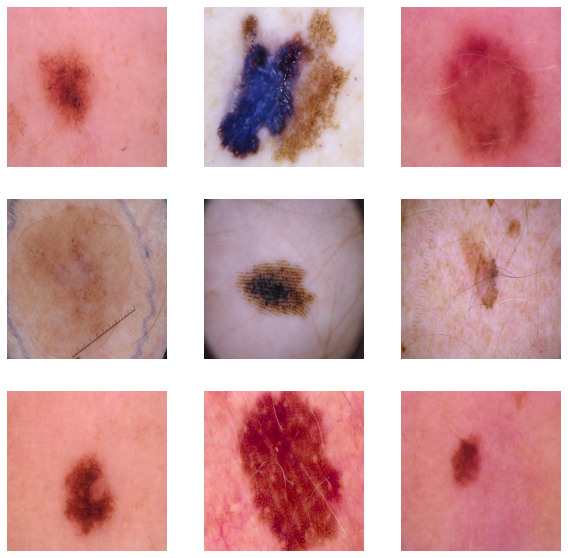

In [ ]:
# Visualizing random images from train samples
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(X_train))
  plt.imshow(X_train[random_num][:,:,:])
  plt.grid(False)
  plt.axis('off')

In [ ]:
# for reproducibility
seed = 100
np.random.seed(seed)

In [ ]:
#Shuffle or data
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]

In [ ]:
print("Shuffle orders example: ", s1)

Shuffle orders example:  [ 685  881 2558 ...   79 1859 1544]


In [ ]:
print("Shape of X_train: ", X_train.shape) 
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2637, 224, 224, 3)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 224, 3)
Shape of y_test:  (660,)


In [ ]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)

In [ ]:
y_train[:5]

array([0, 0, 1, 0, 1])

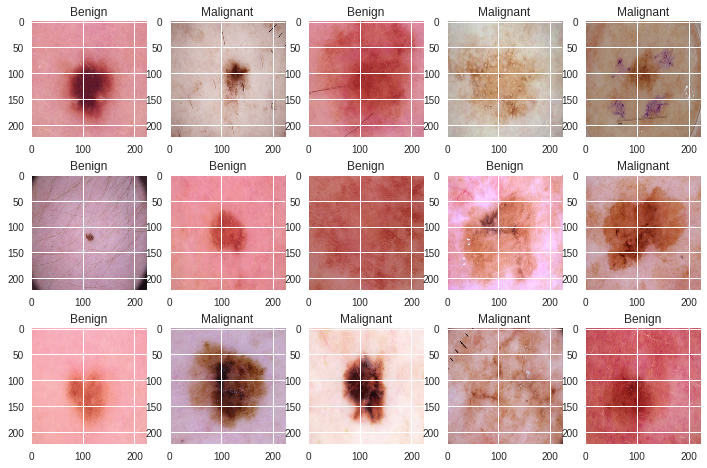

In [ ]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 3

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:
import keras
from keras.utils.np_utils import to_categorical 

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

type(y_train)

numpy.ndarray

In [ ]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
datagen =ImageDataGenerator(horizontal_flip = True,
                   vertical_flip = True,
                   samplewise_center = True,
                   samplewise_std_normalization = True,
                   validation_split = 0.25)

**building our cnn model**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = (224,224,3), activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(MaxPool2D(pool_size = (2,2)))
    # 25% of the nodes will be dropped out
model.add(Dropout(0.25)) 
model.add(Conv2D(128, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
    
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='normal'))
model.add(Dense(128, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'sigmoid'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0

In [ ]:
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


In [ ]:
history = model.fit(X_train,y_train, batch_size = 35, 
                    epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
76/76 [==============================] - 465s 6s/step - loss: 0.8883 - accuracy: 0.5832 - val_loss: 0.6844 - val_accuracy: 0.4758
Epoch 2/20
76/76 [==============================] - 467s 6s/step - loss: 0.5658 - accuracy: 0.6928 - val_loss: 0.4617 - val_accuracy: 0.7742
Epoch 3/20
76/76 [==============================] - 471s 6s/step - loss: 0.4359 - accuracy: 0.7857 - val_loss: 0.4548 - val_accuracy: 0.8000
Epoch 4/20
76/76 [==============================] - 470s 6s/step - loss: 0.4285 - accuracy: 0.7903 - val_loss: 0.3987 - val_accuracy: 0.8258
Epoch 5/20
76/76 [==============================] - 469s 6s/step - loss: 0.3725 - accuracy: 0.8146 - val_loss: 0.3831 - val_accuracy: 0.8288
Epoch 6/20
76/76 [==============================] - 469s 6s/step - loss: 0.3453 - accuracy: 0.8259 - val_loss: 0.4391 - val_accuracy: 0.7455
Epoch 7/20
76/76 [==============================] - 473s 6s/step - loss: 0.3321 - accuracy: 0.8476 - val_loss: 0.3432 - val_accuracy: 0.8242
Epoch 8/20
76

In [ ]:

print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
21/21 [==============================] - 27s 1s/step - loss: 0.5966 - accuracy: 0.8212
test loss, test acc: [0.5965719223022461, 0.821212112903595]


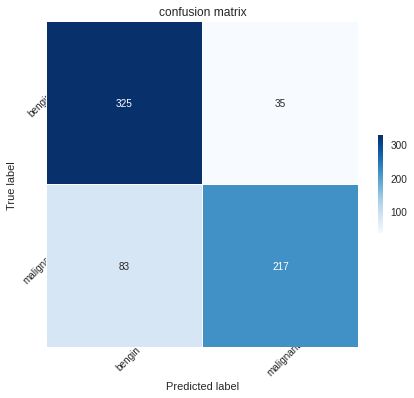

In [ ]:
import copy
from sklearn.metrics import confusion_matrix
label_to_class = {
    'bengin': 0,
    'malignant':1,
}
y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_trues, y_preds, target_names=label_to_class))

              precision    recall  f1-score   support

      bengin       0.80      0.90      0.85       360
   malignant       0.86      0.72      0.79       300

    accuracy                           0.82       660
   macro avg       0.83      0.81      0.82       660
weighted avg       0.83      0.82      0.82       660



In [ ]:
#same model with datagaugmentation

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
es2 = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)

historY = model.fit(datagen.flow(X_train,y_train), batch_size = 35, callbacks=[es,es2] ,
                    epochs = 20, validation_data = datagen.flow(X_test, y_test))

Epoch 1/20
83/83 [==============================] - 493s 6s/step - loss: 0.8490 - accuracy: 0.7334 - val_loss: 0.4776 - val_accuracy: 0.8091
Epoch 2/20
83/83 [==============================] - 492s 6s/step - loss: 0.4135 - accuracy: 0.8070 - val_loss: 0.3870 - val_accuracy: 0.8061
Epoch 3/20
83/83 [==============================] - 485s 6s/step - loss: 0.3912 - accuracy: 0.8104 - val_loss: 0.3936 - val_accuracy: 0.8227
Epoch 4/20
83/83 [==============================] - 484s 6s/step - loss: 0.3675 - accuracy: 0.8210 - val_loss: 0.3583 - val_accuracy: 0.8152
Epoch 5/20
83/83 [==============================] - 482s 6s/step - loss: 0.3490 - accuracy: 0.8339 - val_loss: 0.3956 - val_accuracy: 0.8197
Epoch 00005: early stopping


In [ ]:

print("Evaluate on test data")
results = model.evaluate(datagen.flow(X_test, y_test))
print("test loss, test acc:", results)

Evaluate on test data
21/21 [==============================] - 27s 1s/step - loss: 0.3978 - accuracy: 0.8167
test loss, test acc: [0.39777180552482605, 0.8166666626930237]


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers  import Adam, RMSprop

def build_cnn_model(input_shape = (224, 224, 3), num_classes=2):
    
    model = Sequential()
    
    # adding 64 filters, each filter has a size of 3*3
    # padding is of 2 types: SAME and VALID (SAME means doing the padding around the image, VALID means no padding)
    # kernel initilizer is for intializing the weights of the network --> the default one is glorot_uniform so don't need to mention parameter
    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = input_shape, activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2,2)))
    # 25% of the nodes will be dropped out
    model.add(Dropout(0.25)) 
    
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    # normal initializer draws samples from a truncated normal distribution centered at 0 and SD = sqrt(2/number of input units)
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(128, activation='relu', kernel_initializer='normal'))
    model.add(Dense(50, activation='relu', kernel_initializer='normal'))

    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation = 'sigmoid'))
    
    model.summary()
    
    
    ## OPTIMIZERS are the functions to adjust the weights and minimize the loss
    # Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. 
    # Adam is relatively easy to configure where the default configuration parameters do well on most problems
    # lr is the alpha rate i.e. learning rate
    optimizer= Adam(lr=0.001) 
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    
    return model

In [ ]:
model_cnn = build_cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       2

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Learning rate annealer is used to reduce the learning rate by some percentage after certain number of training iterations/epochs
learning_rate_annealer = ReduceLROnPlateau(monitor='accuracy',
                                          patience=5,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr = 1e-7)
history = model_cnn.fit(datagen.flow(X_train, 
                    y_train), 
                    epochs=20, 
                    batch_size = 64, 
                    verbose=1,validation_data=datagen.flow(X_test,y_test),
                    callbacks=[learning_rate_annealer])



In [ ]:
print("Evaluate on test data")
results = model_cnn.evaluate(datagen.flow(X_test, y_test))
print("test loss, test acc:", results)

Evaluate on test data
21/21 [==============================] - 45s 2s/step - loss: 0.5269 - accuracy: 0.8227
test loss, test acc: [0.5269143581390381, 0.8227272629737854]


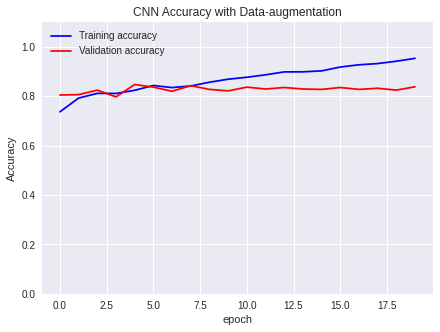

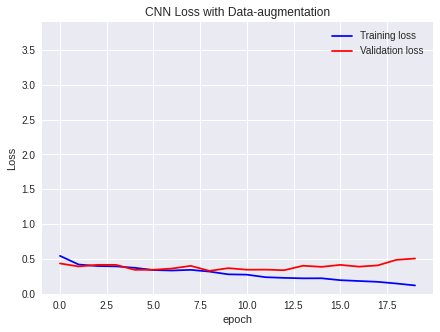

In [ ]:
import matplotlib.pyplot as plt
# Plotting accuracy history
plt.figure(figsize=(7, 5))
#plt.xlim(2, 50)
plt.ylim(0.0, 1.1)
plt.plot(range(20), history.history['accuracy'], color='blue', label='Training accuracy');
plt.plot(range(20), history.history['val_accuracy'], color='r', label='Validation accuracy');
plt.legend();
plt.title('CNN Accuracy with Data-augmentation');
plt.ylabel('Accuracy');
plt.xlabel('epoch');
plt.savefig('CNN_accuracy.jpg', dpi=300, bbox_inches='tight');

# Plotting loss history
plt.figure(figsize=(7, 5))
#plt.xlim(2, 50)
plt.ylim(0.0, 3.9)
plt.plot(range(20), history.history['loss'], color='blue', label='Training loss');
plt.plot(range(20), history.history['val_loss'], color='r', label='Validation loss');
plt.legend();
plt.title('CNN Loss with Data-augmentation');
plt.ylabel('Loss');
plt.xlabel('epoch');
plt.savefig('CNN_loss.jpg', dpi=300, bbox_inches='tight')

In [ ]:
#CNN without data augmentation

In [ ]:
history2 = model_cnn.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size = 64, 
                    verbose=1,validation_data=(X_test,y_test))



Epoch 1/20
42/42 [==============================] - 562s 13s/step - loss: 0.6968 - accuracy: 0.6071 - val_loss: 0.6353 - val_accuracy: 0.7212
Epoch 2/20
42/42 [==============================] - 555s 13s/step - loss: 0.5525 - accuracy: 0.7235 - val_loss: 0.4987 - val_accuracy: 0.7318
Epoch 3/20
42/42 [==============================] - 553s 13s/step - loss: 0.4707 - accuracy: 0.7649 - val_loss: 0.4540 - val_accuracy: 0.7788
Epoch 4/20
42/42 [==============================] - 553s 13s/step - loss: 0.4458 - accuracy: 0.7838 - val_loss: 0.4073 - val_accuracy: 0.7652
Epoch 5/20
42/42 [==============================] - 552s 13s/step - loss: 0.4211 - accuracy: 0.7842 - val_loss: 0.4313 - val_accuracy: 0.7773
Epoch 6/20
42/42 [==============================] - 552s 13s/step - loss: 0.4031 - accuracy: 0.7937 - val_loss: 0.4111 - val_accuracy: 0.8333
Epoch 7/20
42/42 [==============================] - 553s 13s/step - loss: 0.3893 - accuracy: 0.8100 - val_loss: 0.4428 - val_accuracy: 0.8333
Epoch 

In [ ]:

print("Evaluate on test data")
results = model_cnn.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
21/21 [==============================] - 36s 2s/step - loss: 0.5589 - accuracy: 0.8136
test loss, test acc: [0.5588700175285339, 0.8136363625526428]


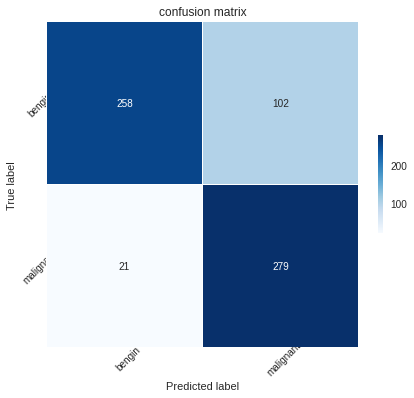

In [ ]:
from sklearn.metrics import confusion_matrix
label_to_class = {
    'bengin': 0,
    'malignant':1,
}
y_preds = model_cnn.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_trues, y_preds, target_names=label_to_class))

              precision    recall  f1-score   support

      bengin       0.92      0.72      0.81       360
   malignant       0.73      0.93      0.82       300

    accuracy                           0.81       660
   macro avg       0.83      0.82      0.81       660
weighted avg       0.84      0.81      0.81       660

